# Clustering Example

In this example we cluster a short trajectory (1000 frames) of the disordered peptide [hiAPP](https://www.ncbi.nlm.nih.gov/pubmed/24021023)

## Load Environment

In [72]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

import subprocess
import numpy as np
import MDAnalysis as mda
import nglview
from tqdm import tqdm
import pathos
import multiprocessing
from scipy.cluster.hierarchy import dendrogram

from idpflex.cluster import cluster_trajectory
from idpflex.properties import (SaxsProperty, SecondaryStructureProperty, propagator_size_weighted_sum)
from idpflex.utils import write_frame
from idpflex.bayes import fit_to_depth

## Loading the Trajectory

In [2]:
simulation = mda.Universe('../tests/data/simulation/hiAPP.pdb', '../tests/data/simulation/hiAPP.xtc')
print('Number of frames in trajectory is ', simulation.trajectory.n_frames)

('Number of frames in trajectory is ', 1000)


## Quick Trajectory Visualization

In [3]:
w_show = nglview.show_mdanalysis(simulation)
w_show

A Jupyter Widget

## Clustering

We cluster the trajectory in two steps:
1. cluster the 1000 frames into 100 small clusters, producing 100 representative structures
2. cluster all 100 representative structures in a hierarchichal tree.

The first step will be obtained by splicing the trajectory into segments of 100 frames, and obtaining 10 representatives for each segment. Thus, we obtain a total of 100 representatives. See [clustering](http://idpflex.readthedocs.io/en/latest/idpflex/cluster.html) for more info.

The two steps process makes more sense with large trajectories, for instance, a trajectory of $10^5$ frames that we cluster into 1000 representatives.

In [4]:
cl = cluster_trajectory(simulation, segment_length=100, n_representatives=100)

Clustering the trajectory:
Creating 100 representatives by partitioning 1000 frames into 10 segments
and retrieving 10 representatives from each segment.
    

100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


## Quick View of the Clustering Tree

<IPython.core.display.Javascript object>


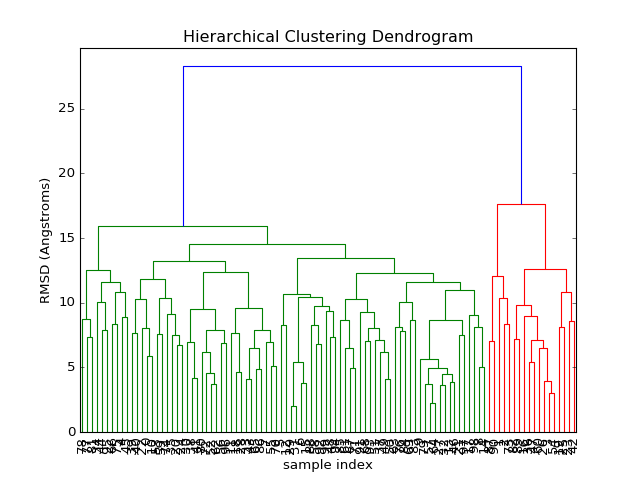

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b'],
 'dcoord': [[0.0, 7.3557078671998131, 7.3557078671998131, 0.0],
  [0.0, 8.7363897880504595, 8.7363897880504595, 7.3557078671998131],
  [0.0, 7.887008106245605, 7.887008106245605, 0.0],
  [0.0, 10.085701057385876, 10.085701057385876, 7.887008106245605],
  [0.0, 8.3585697326404347, 8.358569732

In [73]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('RMSD (Angstroms)')
dendrogram(cl.tree.z,
           #truncate_mode='lastp',  # show only the last p merged clusters
           #p=20,  # show this many cluster at the bottom of the tree
           show_leaf_counts=False,  # otherwise numbers in brackets are counts
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True,  # to get a distribution impression in truncated branches
          )

## Extract PDB Files for Representative Structures
We extract PDB files for each of the 100 representatives and store under directory `/tmp/PDB`

In [54]:
subprocess.call(['mkdir', '-p', '/tmp/PDB'])  # directory to store the PDB files
pdb_names = ['/tmp/PDB/conf_{}.pdb'.format(idx) for idx in cl.idx]
for idx, name in tqdm(list(zip(cl.idx, pdb_names))):
    write_frame(simulation, idx, name)

100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


## Calculation of X-Ray Profiles with CRYSOL

It is assumed that `crysol` is installed in your computer. We store a profile for each representative in directory `/tmp/CRYSOL`.

In [13]:
import pathos
pool = pathos.pools.ProcessPool(processes=multiprocessing.cpu_count())
profiles = list(tqdm(pool.map(SaxsProperty().from_crysol_pdb, pdb_names), total=len(pdb_names)))



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 72881.04it/s]

Once we have the profiles for the 100 representatives, we can calculate the X-ray profiles for any node of the hierarchical tree

In [14]:
crysol_names = ['/tmp/CRYSOL/conf_{}.int'.format(idx) for idx in cl.idx]
[profile.to_ascii(name) for profile, name in zip(profiles, crysol_names)]
propagator_size_weighted_sum(profiles, cl.tree)

## "Experimental" X-Ray profile

We do not have an experimental profile], so we are going to create a fake experimental profile using the profiles from some of the nodes. The task for the fit engine will be to identify which nodes did we use.

Starting from the top of the tree (the root node), we will descend to `level=6`, which contains 7 nodes (the first level is the root node corresponding to `level=0`) We will assign different weights to each of the seven profiles and construct our profile with these weigths.

The profile will be stored as a [SAXS property](http://idpflex.readthedocs.io/en/latest/idpflex/properties.html#idpflex.properties.SaxsProperty)

In [23]:
nodes = cl.tree.nodes_at_depth(6)
weights = [0.00, 0.13, 0.0, 0.55, 0.0, 0.32, 0.00]  # the weights add up to one
# x are the Q-values
x = nodes[0]['saxs'].x
# y are the intensities
y = weights[0] * nodes[0]['saxs'].y
for i, node in enumerate(nodes[1:]):
    y += weights[i] * node['saxs'].y
# Errors simple taken as 10% of the intensities
e = y * 0.1
# Now we create our X-Ray property
exp_saxs = SaxsProperty(qvalues=x, profile=y, errors=e)

we can plot the property

<IPython.core.display.Javascript object>


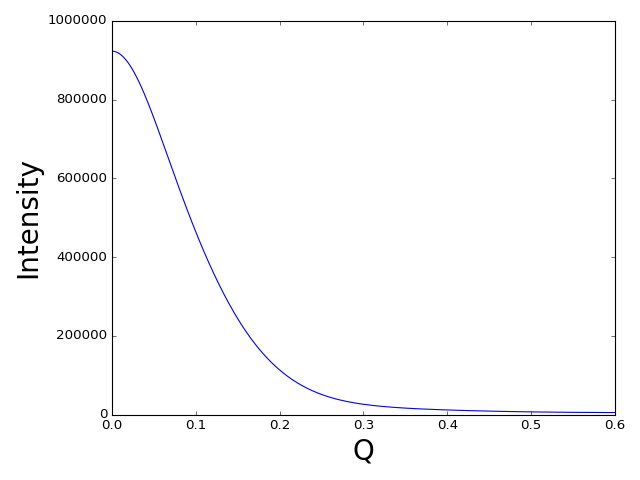

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(exp_saxs.x, exp_saxs.y)
ax.set_xlabel('Q', size=25)
ax.set_ylabel('Intensity', size=25)
plt.tight_layout()

## Fit the Tree Against the Experimental Profile

Starting from the root node, we fit each tree level against the experimental profile, up to a maximum depth (in this case, `level=12`. Then we will inquire the goodnes of fit for each level

In [25]:
fits = fit_to_depth(cl.tree, exp_saxs, exp_saxs.name, max_depth=12)

Fitting at depth = 0
Fitting at depth = 1
Fitting at depth = 2
Fitting at depth = 3
Fitting at depth = 4
Fitting at depth = 5
Fitting at depth = 6
Fitting at depth = 7
Fitting at depth = 8
Fitting at depth = 9
Fitting at depth = 10
Fitting at depth = 11
Fitting at depth = 12


`fits` is a list of [ModelResult](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult) instances, one result for every level. We extract the goodness of fit `\chi^2` and plot versus level

<IPython.core.display.Javascript object>


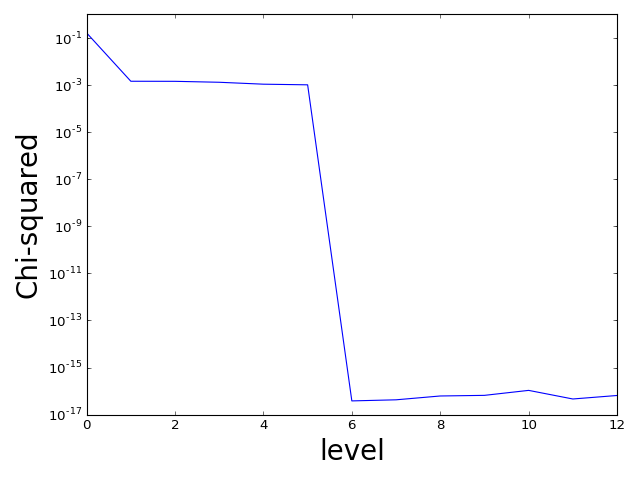

In [74]:
chi2 = [fit.redchi for fit in fits]
fig, ax = plt.subplots(1,1)
ax.set_xlabel('level', size=25)
ax.set_ylabel('Chi-squared', size=25)
ax.set_yscale('log')
ax.plot(chi2)
plt.tight_layout()

the steep drop in orders of magnitude for $\chi^2$ at `level=6` indicates the fit engine successfully fitted the experimental profile.

## Analysis of the Tree Level with Best Fit to Experimental Profile

In [28]:
best_fit = fits[6]

### Weight of Each Cluster
We inquire the weight that the fit engine assigned to each of the seven clusters of `level=6`

In [29]:
for key in best_fit.best_values:
    if 'amplitude' in key:
        print(key, '{:4.2f}'.format(best_fit.best_values[key]))
print(['{:4.2f}'.format(x) for x in weights])  # weights used to construct the experimental profile

('n192_amplitude', '0.32')
('n189_amplitude', '0.00')
('n187_amplitude', '0.00')
('n181_amplitude', '0.00')
('n191_amplitude', '0.00')
('n188_amplitude', '0.13')
('n190_amplitude', '0.55')
['0.00', '0.13', '0.00', '0.55', '0.00', '0.32', '0.00']


The order in which the fitted weights are printed is different that the order of the experimental weight. Object `best_fit.best_values` is a python dictionary and order is not guaranteed for this type of object. However, we can use the node id in the amplitude name to sort the fitted weights from smaller to higher node id.

The fit procedure correctly identified that only three out of the seven nodes are contributing to the experimental profile.

### Representative Structures of the Nodes
Find a representative structure for each of the three nodes contributing to the match of the experimental profile

In [64]:
node_ids = [188, 190, 192]  # ID's for the clusters matching the experimental profile 
leafs = [cl.tree[id].representative(cl.rmsd) for id in node_ids]
repr_names = [pdb_names[l.id] for l in leafs]  # representative structures for each node
print(repr_names)

['/tmp/PDB/conf_722.pdb', '/tmp/PDB/conf_343.pdb', '/tmp/PDB/conf_555.pdb']


In [66]:
view = nglview.show_file(repr_names[0])
view

A Jupyter Widget

In [67]:
view = nglview.show_file(repr_names[1])
view

A Jupyter Widget

In [68]:
view = nglview.show_file(repr_names[2])
view

A Jupyter Widget

## Secondary Structure Analysis

### Calculate Secondary Structure for Nodes of the Tree

It is neccessary to have DSSP executable in your machine. The default name for the executable is `mkdssp`.

We start by calculating the DSSP profile for each of the 100 representatives using their PDB files. After that we calculate the DSSP profile for the rest of nodes in the tree using the
[propagator](http://idpflex.readthedocs.io/en/latest/idpflex/properties.html#idpflex.properties.propagator_size_weighted_sum).

In [75]:
ss_profiles = [SecondaryStructureProperty().from_dssp_pdb(name, command='mkdssp') for name in pdb_names]
propagator_size_weighted_sum(ss_profiles, cl.tree)

In [79]:
propagator_size_weighted_sum(ss_profiles, cl.tree)

### Secondary Structure Content for Matching Nodes
We are interested in the three nodes contributing to the fit of the experimental profile. We plot how much secondary structure each node contains

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


In [ ]:
node_ids = [188, 190, 192]  # ID's for the clusters matching the experimental profile 

<IPython.core.display.Javascript object>


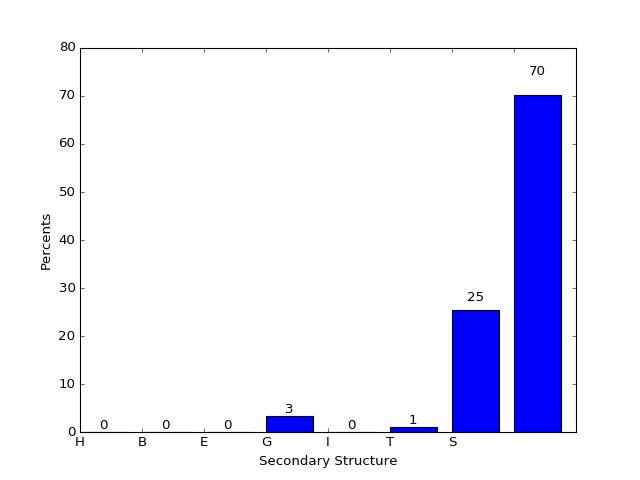

<IPython.core.display.Javascript object>


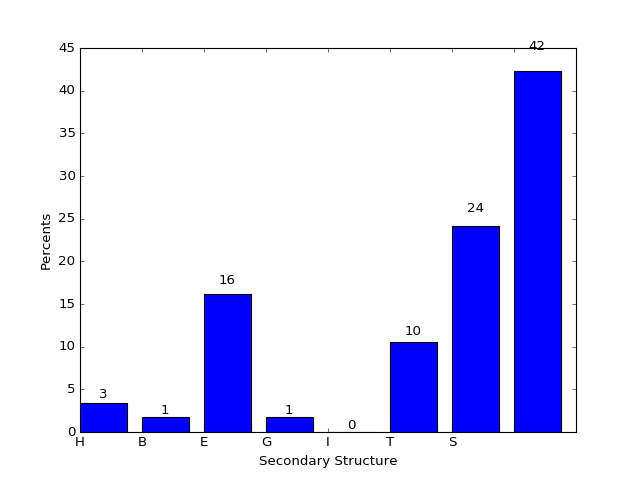

<IPython.core.display.Javascript object>


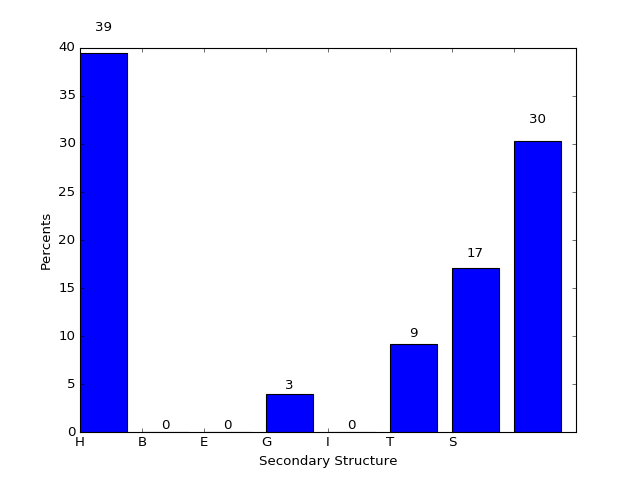

[None, None, None]

In [83]:
[cl.tree[id]['ss'].plot(kind='percents') for id in node_ids]

### Secondary Structure Probabilities of Matching Nodes

Each node is actually a cluster or ensemble of structures, out of the 100 representative structures. Thus for a given node, each residue has a certain probability to be in one of the different DSSP states.

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


<IPython.core.display.Javascript object>


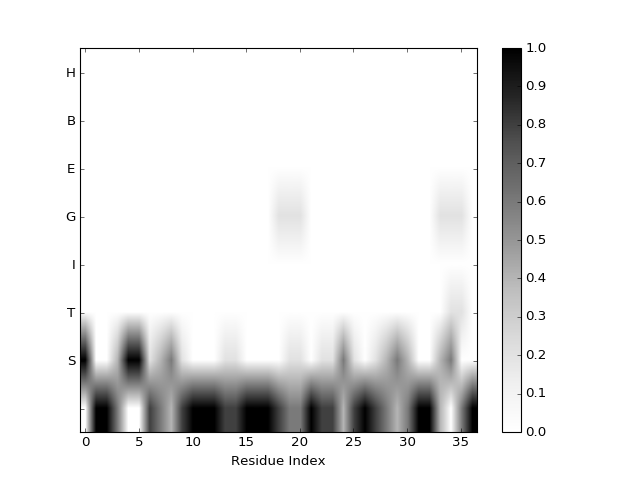

<IPython.core.display.Javascript object>


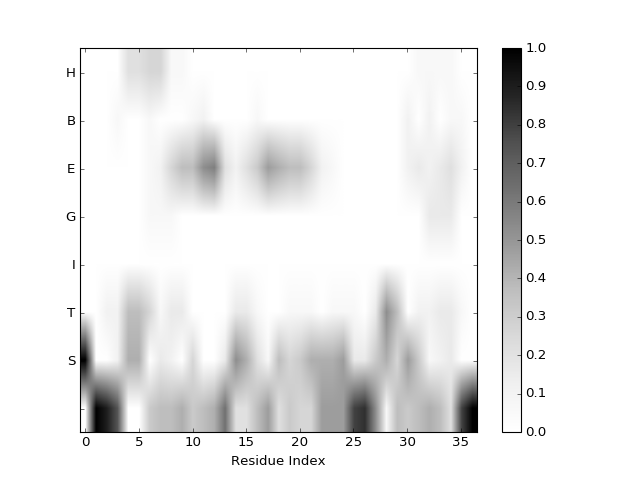

<IPython.core.display.Javascript object>


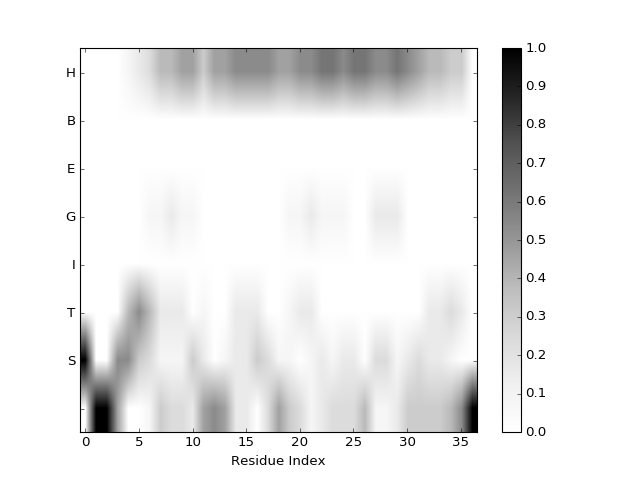

[None, None, None]

In [85]:
[cl.tree[id]['ss'].plot(kind='node') for id in node_ids]

### Ensemble Secondary Structure of Matching Nodes

Each node is actually a cluster or ensemble of structures, out of the 100 representative structures. Thus for a given node we can plot the secondary structure of each structure belonging to the node

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


In [87]:
#[cl.tree[id]['ss'].plot(kind='leafs') for id in node_ids]
cl.tree[node_ids[1]]['ss'].plot(kind='leafs')

<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'leafs'